In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
from skimage import io, transform
import glob
import tables


timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [64]:
from iterative_lda import IterativeLDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Load P53 data

Start by clearing any row with a question mark

In [23]:
RAW_DATA = './data/iterative_lda/p53/p53_old_2010/K8.data' 
CLEANED_DATA = './data/iterative_lda/p53/p53_old_2010/K8.data_cleaned.csv'

raise ValueError("Don't run again unless I remove this")
with open(RAW_DATA, 'r') as raw_data:
    with open(CLEANED_DATA, 'w') as output:
        line = 'start'
        while line != '':
            line = raw_data.readline()
            if '?' not in line:
                line = line.replace('inactive,', '1').replace('active,', '0')
                output.write(line)

In [24]:
p53 = pandas.read_csv(CLEANED_DATA, header=None)

In [25]:
p53.head(n=20)

,0,1,2,3,4,5,6,7,8,9,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.006,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007,1
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,1
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.019,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,1
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.051,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049,1
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,1
5,-0.150,0.016,-0.014,0.000,0.016,-0.123,-0.004,-0.002,-0.005,0.010,...,0.000,-0.033,-0.032,0.029,-0.052,-0.029,-0.006,0.004,0.023,1
6,-0.158,0.002,-0.019,-0.028,-0.008,-0.101,0.011,0.005,0.001,0.003,...,0.015,-0.025,-0.003,0.017,-0.017,-0.009,-0.001,0.017,0.012,1
7,-0.152,0.009,-0.015,-0.008,0.004,-0.120,-0.002,-0.002,-0.007,0.004,...,-0.014,-0.009,-0.007,0.009,-0.027,-0.012,-0.009,0.008,0.021,1
8,-0.172,-0.028,0.003,-0.045,-0.055,-0.078,0.039,0.011,0.006,-0.020,...,0.016,0.031,-0.059,0.050,0.010,-0.005,0.137,0.098,-0.015,1
9,-0.164,-0.019,-0.011,-0.037,-0.031,-0.081,0.029,0.012,0.007,-0.010,...,0.012,0.006,0.019,0.022,0.011,-0.012,0.002,0.014,-0.009,1


## Fit an LDA model to a 100 rows, just to see it fits well

In [56]:
minimal_p53 = p53.head(n=100)
minimal_p53_X = minimal_p53.iloc[:,:-1]
minimal_p53_y = minimal_p53.iloc[:,-1:].as_matrix().ravel()
print(minimal_p53_X.shape, minimal_p53_y.shape)

lda = LinearDiscriminantAnalysis()
lda.fit(minimal_p53_X, minimal_p53_y)
np.sum(lda.predict(minimal_p53_X) == minimal_p53_y) / minimal_p53_y.shape[0]

(100, 5408) (100,)


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.97999999999999998

## Fit an LDA model to the entire data-set

In [61]:
p53_X = p53.iloc[:,:-1]
p53_y = p53.iloc[:,-1:].as_matrix().ravel()

X, X_test, y, y_test = train_test_split(p53_X, p53_y, test_size=0.1, 
                                        random_state=RANDOM_SEED,
                                       stratify=p53_y)

X.shape, y.shape, X_test.shape, y_test.shape

((14932, 5408), (14932,), (1660, 5408), (1660,))

In [62]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
print(np.sum(lda.predict(X) == y) / y.shape[0])
print(np.sum(lda.predict(X_test) == y_test) / y_test.shape[0])

0.996182694883
0.977710843373


In [73]:
raise ValueError('Dont run again')
ilda = IterativeLDA(10)
transformed_X = ilda.fit_transform(X, y)
transformed_X_test = ilda.transform(X_test)

In [74]:
rfc = RandomForestClassifier(verbose=True)
rfc.fit(transformed_X, y)

print(np.sum(rfc.predict(transformed_X) == y) / y.shape[0])
print(np.sum(rfc.predict(transformed_X_test) == y_test) / y_test.shape[0])

0.99986605947
0.968674698795


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [75]:
svm = SVC(verbose=True)
svm.fit(transformed_X, y)

print(np.sum(svm.predict(transformed_X) == y) / y.shape[0])
print(np.sum(svm.predict(transformed_X_test) == y_test) / y_test.shape[0])

[LibSVM]0.997923921779
0.945180722892


## Looks like LDA handles the older p53 dataset with ease. Let's try the newer?

In [77]:
NEW_P53_DATA = './data/iterative_lda/p53/Data Sets/K9.data_cleaned.csv'
new_p53 = pandas.read_csv(NEW_P53_DATA, header=None)
new_p53.shape

(31159, 5409)

In [78]:
new_p53.head(n=20)

,0,1,2,3,4,5,6,7,8,9,...,5399,5400,5401,5402,5403,5404,5405,5406,5407,5408
0,-0.161,-0.014,0.002,-0.036,-0.033,-0.093,0.025,0.005,0.000,-0.015,...,0.006,0.013,0.021,0.020,0.016,-0.011,0.003,0.010,-0.007,1
1,-0.158,-0.002,-0.012,-0.025,-0.012,-0.106,0.013,0.005,0.000,-0.002,...,0.002,-0.008,0.007,0.015,-0.008,-0.011,-0.004,0.013,0.005,1
2,-0.169,-0.025,-0.010,-0.041,-0.045,-0.069,0.038,0.014,0.008,-0.014,...,0.019,0.010,0.025,0.025,0.021,-0.012,0.006,0.016,-0.018,1
3,-0.183,-0.051,-0.023,-0.077,-0.092,-0.015,0.071,0.027,0.020,-0.019,...,0.051,0.012,0.050,0.038,0.051,-0.015,0.017,0.027,-0.049,1
4,-0.154,0.005,-0.011,-0.013,-0.002,-0.115,0.005,0.002,-0.003,0.002,...,-0.011,0.012,0.009,0.003,-0.001,0.002,-0.006,0.009,0.013,1
5,-0.150,0.016,-0.014,0.000,0.016,-0.123,-0.004,-0.002,-0.005,0.010,...,0.000,-0.033,-0.032,0.029,-0.052,-0.029,-0.006,0.004,0.023,1
6,-0.158,0.002,-0.019,-0.028,-0.008,-0.101,0.011,0.005,0.001,0.003,...,0.015,-0.025,-0.003,0.017,-0.017,-0.009,-0.001,0.017,0.012,1
7,-0.152,0.009,-0.015,-0.008,0.004,-0.120,-0.002,-0.002,-0.007,0.004,...,-0.014,-0.009,-0.007,0.009,-0.027,-0.012,-0.009,0.008,0.021,1
8,-0.172,-0.028,0.003,-0.045,-0.055,-0.078,0.039,0.011,0.006,-0.020,...,0.016,0.031,-0.059,0.050,0.010,-0.005,0.137,0.098,-0.015,1
9,-0.164,-0.019,-0.011,-0.037,-0.031,-0.081,0.029,0.012,0.007,-0.010,...,0.012,0.006,0.019,0.022,0.011,-0.012,0.002,0.014,-0.009,1


In [79]:
new_p53_X = new_p53.iloc[:,:-1]
new_p53_y = new_p53.iloc[:,-1:].as_matrix().ravel()

new_X, new_X_test, new_y, new_y_test = train_test_split(new_p53_X, new_p53_y, test_size=0.1, 
                                        random_state=RANDOM_SEED,
                                       stratify=new_p53_y)

new_X.shape, new_y.shape, new_X_test.shape, new_y_test.shape

((28043, 5408), (28043,), (3116, 5408), (3116,))

In [81]:
new_lda = LinearDiscriminantAnalysis()
new_lda.fit(new_X, new_y)
print(np.sum(new_lda.predict(new_X) == new_y) / new_y.shape[0])
print(np.sum(new_lda.predict(new_X_test) == new_y_test) / new_y_test.shape[0])

0.996041792961
0.991655969191


In [ ]:
raise ValueError('Dont run again')
new_ilda = IterativeLDA(10)
new_transformed_X = new_ilda.fit_transform(new_X, new_y)
new_transformed_X_test = new_ilda.transform(new_X_test)

In [ ]:
rfc = RandomForestClassifier(verbose=True)
rfc.fit(transformed_X, new_y)

print(np.sum(rfc.predict(new_transformed_X) == new_y) / new_y.shape[0])
print(np.sum(rfc.predict(new_transformed_X_test) == new_y_test) / new_y_test.shape[0])

In [ ]:
svm = SVC(verbose=True)
svm.fit(new_transformed_X, new_y)

print(np.sum(svm.predict(new_transformed_X) == new_y) / new_y.shape[0])
print(np.sum(svm.predict(new_transformed_X_test) == new_y_test) / new_y_test.shape[0])

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


FONT_SIZE = 12


def plot_data_in_R3(first_class, second_class, first_test, second_test, ax):
    ax.scatter(first_class[:, 0], first_class[:, 1], first_class[:, 2], label='$c=1$')
    ax.scatter(second_class[:, 0], second_class[:, 1], second_class[:, 2], label='$c=2$')

    ax.scatter(first_test[:, 0], first_test[:, 1], first_test[:, 2], label='$c=1$ test set')
    ax.scatter(second_test[:, 0], second_test[:, 1], second_test[:, 2], label='$c=2$ test set')

    ax.legend(loc=2, fontsize=FONT_SIZE)
    ax.set_xlabel('X', size=FONT_SIZE)
    ax.set_ylabel('Y', size=FONT_SIZE)
    ax.set_zlabel('Z', size=FONT_SIZE)
    
    
def plot_lda_projection(transformed_X, transformed_X_test, n_1, n_test_1, title, ax):
    ax.scatter(transformed_X[:n_1], [1] * n_1, 
               label='$c=1$', alpha=0.33)
    ax.scatter(transformed_X[n_1:], [2] * (transformed_X.shape[0] - n_1), 
               label='$c=2$', alpha=0.33)
    
    ax.scatter(transformed_X_test[:n_test_1], [0.5] * n_test_1, 
               label='$c=1$ test set', alpha=0.33)
    ax.scatter(transformed_X_test[n_test_1:], [2.5] * (transformed_X_test.shape[0] - n_test_1), 
               label='$c=2$ test set', alpha=0.33)
    
    ax.set_ylim(0, 3)
    ax.legend(loc='best', fontsize=FONT_SIZE)
    ax.set_xlabel('X', size=FONT_SIZE)
    ax.set_ylabel('Y', size=FONT_SIZE)
    ax.set_title(title)
    

def nullspace_using_svd(A, eps=1e-15):
    u, s, v = np.linalg.svd(A)
    null_space = v[s.shape[0]:]
    return null_space.T
    
    
def plot_classifier(reg, transformed_X, transformed_ns_X,
                             transformed_X_test, transformed_ns_X_test,
                             n_1, n_test_1, ax):
    ax.scatter(transformed_X[:n_1], transformed_ns_X[:n_1], label='$c=1$')
    ax.scatter(transformed_X[n_1:], transformed_ns_X[n_1:], label='$c=2$')
    
    ax.scatter(transformed_X_test[:n_test_1], transformed_ns_X_test[:n_test_1], label='$c=1$ test set')
    ax.scatter(transformed_X_test[n_test_1:], transformed_ns_X_test[n_test_1:], label='$c=2$ test set')

    ax.legend(loc=2, fontsize=FONT_SIZE)
    ax.set_xlabel('First LDA projection', size=FONT_SIZE)
    ax.set_ylabel('Second LDA projection', size=FONT_SIZE)
    ax.set_title('Classifier results')
    
    
def lda_projection_experiment(first_class, second_class, first_test, second_test,
                             classifier_constructor, classify_raw_data=False, **kwargs): 
                            # kwargs passed to classifer
    n_1, d = first_class.shape
    n_test_1, _ = first_test.shape
    n_2, _ = second_class.shape
    n_test_2, _ = second_test.shape
    
    plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, hspace=0.3)
    if 3 == d:
        plot_data_in_R3(first_class, second_class, first_test, second_test, 
                        plt.subplot(gs[0, 0], projection='3d'))
    
    # Train and test set cleanup
    X = np.vstack([first_class, second_class])
    y = np.asarray([1] * n_1 + [2] * n_2)
    X_test = np.vstack([first_test, second_test])
    y_test = np.asarray([1] *  n_test_1 + [2] * n_test_2)
    
    if classify_raw_data:
        # Attempt to classify on the raw data
        raw_data_classifier = classifier_constructor(**kwargs)
        raw_data_classifier.fit(X, y)

        print('Raw classifier:')
        raw_classifier_train_acc = np.sum(raw_data_classifier.predict(X) == y) / y.shape[0]
        raw_classifier_test_acc = np.sum(raw_data_classifier.predict(X_test) == y_test) / y_test.shape[0]
        print('Train rediction accuracy:', raw_classifier_train_acc)
        print('Test Prediction accuracy:', raw_classifier_test_acc)
    else:
        raw_classifier_train_acc = 'N/A'
        raw_classifier_test_acc = 'N/A'
    
    # First LDA projection
    ilda = IterativeLDA(1)
    transformed_X = ilda.fit_transform(X, y)
    transformed_X_test = ilda.transform(X_test)
    plot_lda_projection(transformed_X, transformed_X_test, n_1, n_test_1, 
                        'First LDA Projection', plt.subplot(gs[0, 1]))
    first_lda = ilda.ldas_[0]
    print('First LDA projection:')
    first_train_acc = np.sum(first_lda.predict(X) == y) / y.shape[0]
    first_test_acc = np.sum(first_lda.predict(X_test) == y_test) / y_test.shape[0]
    print('Train prediction accuracy:', first_train_acc)
    print('Test prediction accuracy:', first_test_acc)
    
    # Second LDA projection
    ilda.add_components(1, X, y)
    transformed_ns_X = ilda.transform(X)[:,1]
    transformed_ns_X_test = ilda.transform(X_test)[:,1]
    plot_lda_projection(transformed_ns_X, transformed_ns_X_test, n_1, n_test_1, 
                        'Second LDA Projection', plt.subplot(gs[1, 0]))
    
    ns = nullspace_using_svd(first_lda.coef_)
    X_ns = X.dot(ns)
    X_ns_test = X_test.dot(ns)
    
    second_lda = ilda.ldas_[1]
    print('Second LDA projection:')
    second_train_acc = np.sum(second_lda.predict(X_ns) == y) / y.shape[0]
    second_test_acc = np.sum(second_lda.predict(X_ns_test) == y_test) / y_test.shape[0]
    print('Train rediction accuracy:', second_train_acc)
    print('Test Prediction accuracy:', second_test_acc)
    
    # Run a custom classifier on both LDA'd dimensions
    both_transformed_X = ilda.transform(X)
    both_transformed_X_test = ilda.transform(X_test)

    classifier = classifier_constructor(**kwargs)
    classifier.fit(both_transformed_X, y)
    plot_classifier(classifier, transformed_X, transformed_ns_X,
                    transformed_X_test, transformed_ns_X_test,
                    n_1, n_test_1, plt.subplot(gs[1, 1]))
    
    print('Combined classifier:')
    classifier_train_acc = np.sum(classifier.predict(both_transformed_X) == y) / y.shape[0]
    classifier_test_acc = np.sum(classifier.predict(both_transformed_X_test) == y_test) / y_test.shape[0]
    print('Train rediction accuracy:', classifier_train_acc)
    print('Test Prediction accuracy:', classifier_test_acc)
    
    plt.show()
    
    headers = ('Dataset', 'Raw Classifier', 'First LDA', 'Second LDA', 'I-LDA Classifier')
    
    rows = [
        ('Train', raw_classifier_train_acc, first_train_acc, second_train_acc, classifier_train_acc),
        ('Test', raw_classifier_test_acc, first_test_acc, second_test_acc, classifier_test_acc)
    ]
    
    print(tabulate.tabulate(rows, headers, tablefmt='fancy_grid'))


## Data in $\mathbb{R}^3$, diagonal covariance

First LDA projection:
Train prediction accuracy: 0.7285
Test prediction accuracy: 0.745
Second LDA projection:
Train rediction accuracy: 0.544
Test Prediction accuracy: 0.565
Combined classifier:
Train rediction accuracy: 0.7355
Test Prediction accuracy: 0.75


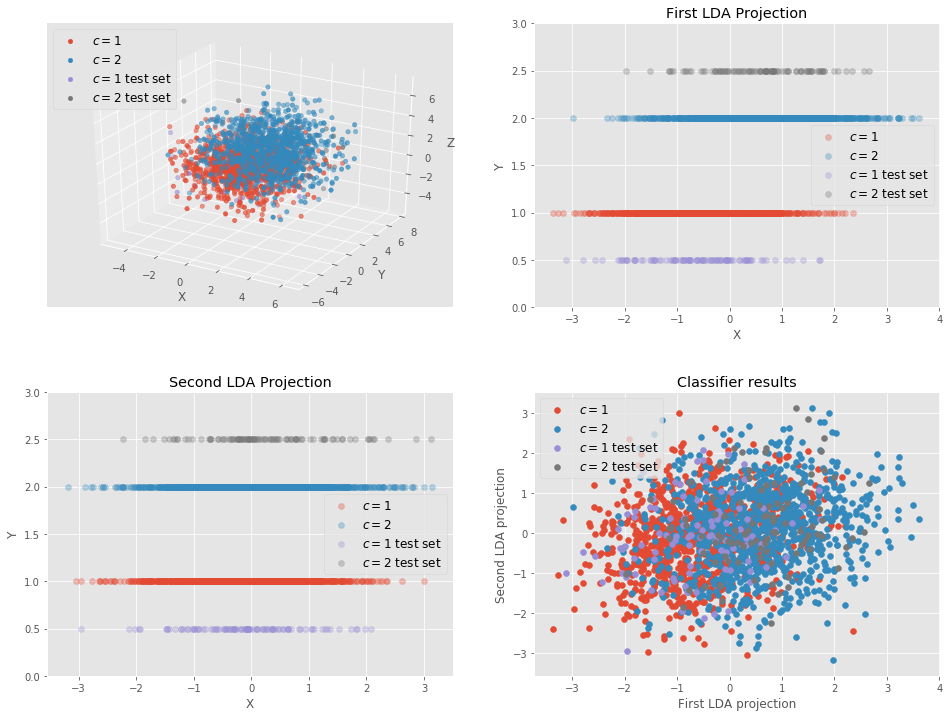

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │ Raw Classifier   │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │ N/A              │      0.7285 │        0.544 │             0.7355 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │ N/A              │      0.745  │        0.565 │             0.75   │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [39]:
np.random.seed(RANDOM_SEED)

D = 3

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

## Data in $\mathbb{R}^3$, full covariance

In [ ]:
np.random.seed(RANDOM_SEED)

D = 3

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 10 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 10 + np.eye(D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

## Data in $\mathbb{R}^{10}$, full covariance

In [ ]:
np.random.seed(RANDOM_SEED)

D = 10

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

## Data in $\mathbb{R}^{10}$, full covariance

In [ ]:
np.random.seed(RANDOM_SEED)

D = 10

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 10 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 2.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 10 + np.eye(D)

N = 1000
TEST_N = 100

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test)

First LDA projection:
Train prediction accuracy: 0.70515
Test prediction accuracy: 0.7005
Second LDA projection:
Train rediction accuracy: 0.6128
Test Prediction accuracy: 0.607
Combined classifier:
Train rediction accuracy: 0.70385
Test Prediction accuracy: 0.708


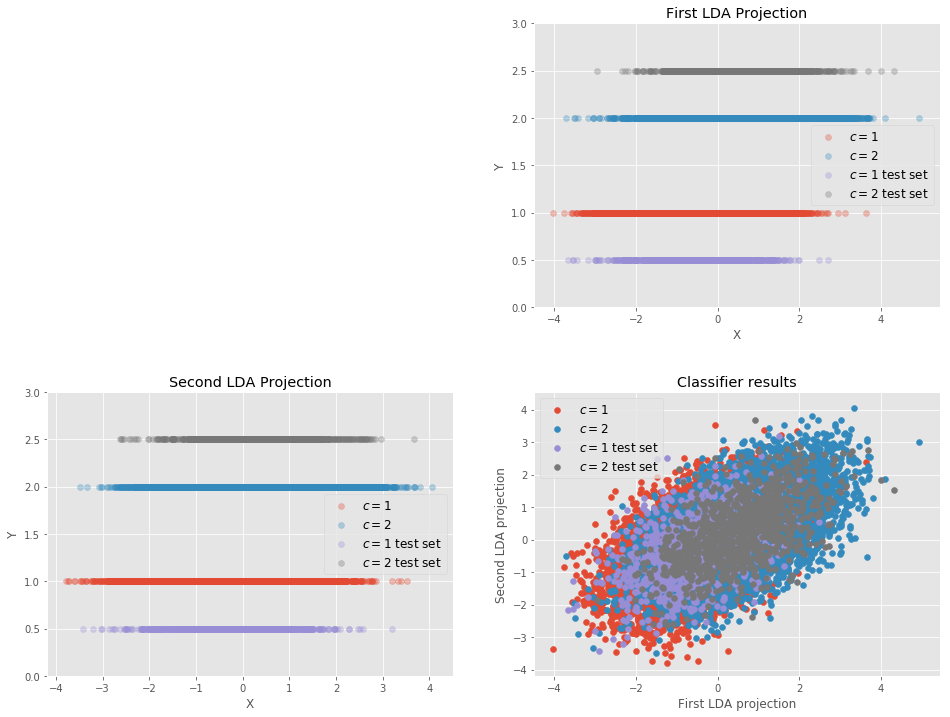

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │ Raw Classifier   │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │                  │     0.70515 │       0.6128 │            0.70385 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │                  │     0.7005  │       0.607  │            0.708   │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [24]:
np.random.seed(RANDOM_SEED)

D = 100

FIRST_MEAN = np.random.uniform(0, 1, D) # np.asarray([1, 0, 1])
# FIRST_COV = np.eye(D) * np.random.uniform(2, 4, D)
FIRST_COV = np.ones((D, D)) * np.random.uniform(0.5, 4.5, (D, D))
FIRST_COV = FIRST_COV.T.dot(FIRST_COV) / 5 + np.eye(D)

SECOND_MEAN = np.random.uniform(1, 2, D) # np.asarray([0, 2, 2])
# SECOND_COV = np.eye(D) * np.random.uniform(2, 4, D)
SECOND_COV = np.ones((D, D)) * np.random.uniform(0.5, 4.5, (D, D))
SECOND_COV = SECOND_COV.T.dot(SECOND_COV) / 5 + np.eye(D)

N = 10000
TEST_N = 1000

first_class = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, N)
second_class = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, N)

first_test = np.random.multivariate_normal(FIRST_MEAN, FIRST_COV, TEST_N)
second_test = np.random.multivariate_normal(SECOND_MEAN, SECOND_COV, TEST_N)

lda_projection_experiment(first_class, second_class, first_test, second_test,
                         SVC)

## Try the Wisconsin breast cancer dataset

First LDA projection:
Train prediction accuracy: 0.962890625
Test prediction accuracy: 0.929824561404
Second LDA projection:
Train rediction accuracy: 0.96875
Test Prediction accuracy: 0.929824561404
Combined classifier:
Train rediction accuracy: 0.978515625
Test Prediction accuracy: 0.964912280702


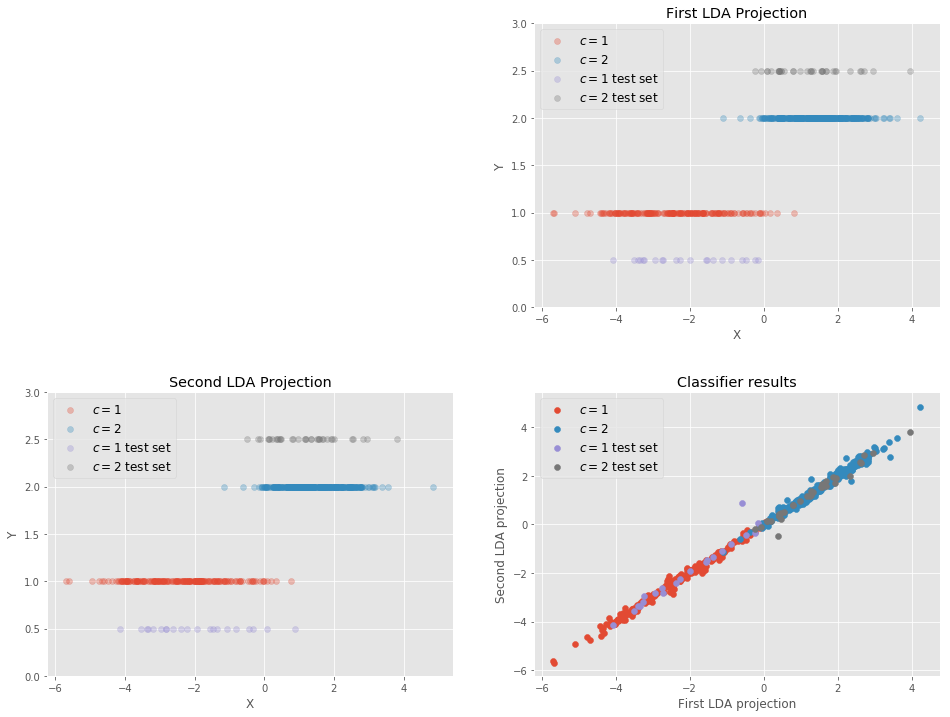

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │ Raw Classifier   │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │ N/A              │    0.962891 │     0.96875  │           0.978516 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │ N/A              │    0.929825 │     0.929825 │           0.964912 │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [41]:
from sklearn import datasets 
from sklearn.model_selection import train_test_split

wisconsin = datasets.load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(wisconsin.data, wisconsin.target,
                                                    stratify=wisconsin.target, test_size=0.1)
                                                   # random_state=RANDOM_SEED)

first_train = X_train[y_train == 0]
second_train = X_train[y_train == 1]
first_test = X_test[y_test == 0]
second_test = X_test[y_test == 1]


lda_projection_experiment(first_train, second_train, first_test, second_test,
                         SVC)

## Experimenting with the cats and dogs dataset

In [ ]:
from glob import glob

min_x = (float('Inf'), float('Inf'))
min_y = (float('Inf'), float('Inf'))

for image in glob('./data/iterative_lda/dogs_cats/train/*'):
    shape = io.imread(image).shape
    if shape[0] < min_x[0]:
        min_x = shape
    if shape[1] < min_y[1]:
        min_y = shape

print(min_x)
print(min_y)

In [18]:
NEW_IMAGE_SIZE = (64, 64, 3)
TRAIN_SIZE = 1000
TEST_SIZE = 100

dog_image_paths = glob.glob('./data/iterative_lda/dogs_cats/train/dog.*')
cat_image_paths = glob.glob('./data/iterative_lda/dogs_cats/train/dog.*')


def prepare_dataset(paths, train_size=TRAIN_SIZE, test_size=TEST_SIZE, 
                    image_size=NEW_IMAGE_SIZE):
    both_paths = np.random.choice(dog_image_paths, TRAIN_SIZE + TEST_SIZE, False)
    train_paths = both_paths[:train_size]
    test_paths = both_paths[train_size:]
    
    train_images = io.imread_collection(train_paths)
    test_images = io.imread_collection(test_paths)

    resized_train = [transform.resize(image, image_size) for image in train_images]
    resized_test = [transform.resize(image, image_size) for image in test_images]
    
    train_mean = np.mean(resized_train, axis=0)
    centered_train = resized_train - train_mean
    centered_test = resized_test - train_mean
    
    reshaped_train = centered_train.reshape(centered_train.shape[0], -1) 
    reshaped_test = centered_test.reshape(centered_test.shape[0], -1) 

    return reshaped_train, reshaped_test


dog_train, dog_test = prepare_dataset(dog_image_paths)
cat_train, cat_test = prepare_dataset(cat_image_paths)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


First LDA projection:
Train prediction accuracy: 0.4975
Test prediction accuracy: 0.43
Second LDA projection:
Train rediction accuracy: 0.44
Test Prediction accuracy: 0.535
Combined classifier:
Train rediction accuracy: 0.618
Test Prediction accuracy: 0.515


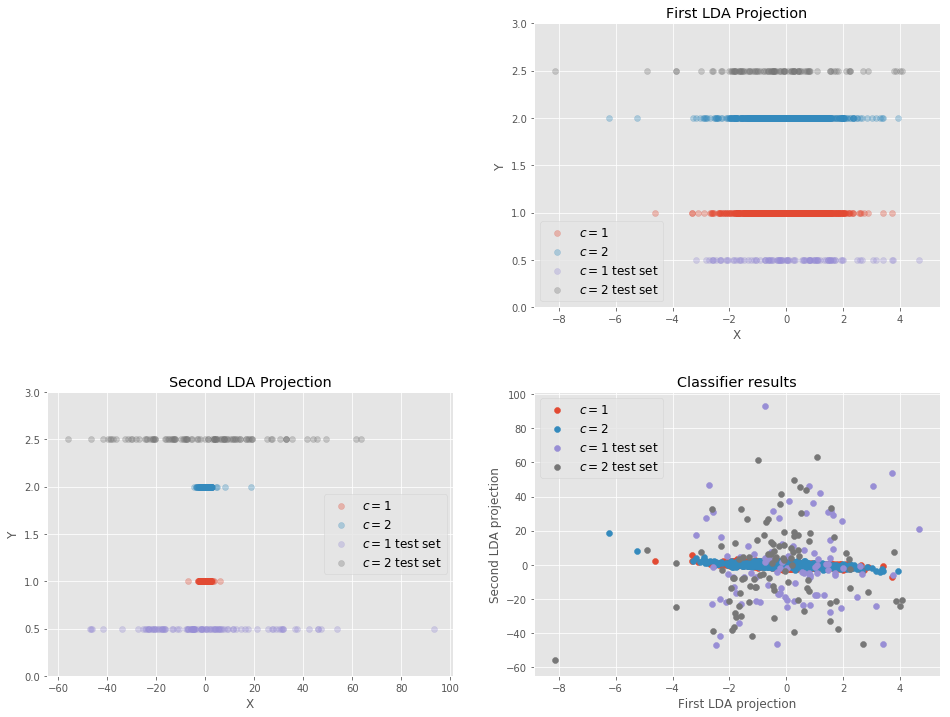

╒═══════════╤══════════════════╤═════════════╤══════════════╤════════════════════╕
│ Dataset   │ Raw Classifier   │   First LDA │   Second LDA │   I-LDA Classifier │
╞═══════════╪══════════════════╪═════════════╪══════════════╪════════════════════╡
│ Train     │ N/A              │      0.4975 │        0.44  │              0.618 │
├───────────┼──────────────────┼─────────────┼──────────────┼────────────────────┤
│ Test      │ N/A              │      0.43   │        0.535 │              0.515 │
╘═══════════╧══════════════════╧═════════════╧══════════════╧════════════════════╛


In [42]:
lda_projection_experiment(dog_train, cat_train, dog_test, cat_test,
                         SVC)

In [43]:
X = np.vstack([dog_train, cat_train])
y = np.asarray([1] * TRAIN_SIZE + [2] * TRAIN_SIZE)
X_test = np.vstack([dog_test, cat_test])
y_test = np.asarray([1] *  TEST_SIZE + [2] * TEST_SIZE)

In [44]:
ten_d_ilda = IterativeLDA(10)
ten_d_X = ten_d_ilda.fit_transform(X, y)
ten_d_X_test = ten_d_ilda.transform(X_test)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [46]:
from sklearn.ensemble import RandomForestClassifier

train_accuracies = []
test_accuracies = []

for i in range(10):
    rfc = RandomForestClassifier()
    current_X = X[:,:i + 1]
    current_X_test = X_test[:,:i + 1]
    rfc.fit(current_X, y)
    
    train_accuracies.append(np.sum(rfc.predict(current_X) == y) / y.shape[0])
    test_accuracies.append(np.sum(rfc.predict(current_X_test) == y_test) / y_test.shape[0])
    
headers = ['Dataset'] + list([str(i + 1) for i in range(10)])
    
rows = [
    ['Train'] + train_accuracies,
    ['Test'] + test_accuracies,
]

print(tabulate.tabulate(rows, headers, tablefmt='fancy_grid'))

╒═══════════╤═══════╤════════╤════════╤════════╤════════╤════════╤═══════╤═══════╤════════╤═══════╕
│ Dataset   │     1 │      2 │      3 │      4 │      5 │      6 │     7 │     8 │      9 │    10 │
╞═══════════╪═══════╪════════╪════════╪════════╪════════╪════════╪═══════╪═══════╪════════╪═══════╡
│ Train     │ 0.943 │ 0.9725 │ 0.9745 │ 0.9775 │ 0.9785 │ 0.9815 │ 0.977 │ 0.981 │ 0.9785 │ 0.978 │
├───────────┼───────┼────────┼────────┼────────┼────────┼────────┼───────┼───────┼────────┼───────┤
│ Test      │ 0.48  │ 0.52   │ 0.5    │ 0.47   │ 0.54   │ 0.54   │ 0.465 │ 0.515 │ 0.485  │ 0.56  │
╘═══════════╧═══════╧════════╧════════╧════════╧════════╧════════╧═══════╧═══════╧════════╧═══════╛


In [47]:
from sklearn.ensemble import RandomForestClassifier

train_accuracies = []
test_accuracies = []

for i in range(10):
    print(i + 1)
    svm = SVC()
    current_X = X[:,:i + 1]
    current_X_test = X_test[:,:i + 1]
    svm.fit(current_X, y)
    
    train_accuracies.append(np.sum(svm.predict(current_X) == y) / y.shape[0])
    test_accuracies.append(np.sum(svm.predict(current_X_test) == y_test) / y_test.shape[0])
    
headers = ['Dataset'] + list([str(i + 1) for i in range(10)])
    
rows = [
    ['Train'] + train_accuracies,
    ['Test'] + test_accuracies,
]

print(tabulate.tabulate(rows, headers, tablefmt='fancy_grid'))

1
2
3
4
5
6
7
8
9
10
╒═══════════╤═══════╤════════╤═══════╤═══════╤════════╤═══════╤════════╤═══════╤═══════╤═══════╕
│ Dataset   │     1 │      2 │     3 │     4 │      5 │     6 │      7 │     8 │     9 │    10 │
╞═══════════╪═══════╪════════╪═══════╪═══════╪════════╪═══════╪════════╪═══════╪═══════╪═══════╡
│ Train     │ 0.506 │ 0.5075 │ 0.509 │ 0.506 │ 0.5045 │ 0.511 │ 0.5145 │ 0.514 │ 0.516 │ 0.513 │
├───────────┼───────┼────────┼───────┼───────┼────────┼───────┼────────┼───────┼───────┼───────┤
│ Test      │ 0.455 │ 0.475  │ 0.465 │ 0.465 │ 0.465  │ 0.465 │ 0.455  │ 0.45  │ 0.455 │ 0.465 │
╘═══════════╧═══════╧════════╧═══════╧═══════╧════════╧═══════╧════════╧═══════╧═══════╧═══════╛


In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

In [ ]:
lda.coef_ 
lda.scalings_

In [28]:
t = ilda.transform(X)

(array([ 0.26467614,  0.06585161,  0.4654555 , ..., -0.15892119,
        -0.18931949,  0.21795009]), array([-0.19227536,  0.26467614]))